In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

In [3]:
# Load Data
import os
import sys
import torch

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_576_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

tft = load_tft_from_gcs(model_name="Mamba2_12h_576c_MES", training_dataset=training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tft = tft.to(device)   # <— this must move *every* sub‐module (including the Mamba blocks)  
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK
[2025-08-20 19:27:44.582787] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/Mamba2_12h_576c_MES/


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [4]:
valid_minutes = set(range(21*60, 24*60, 5)) | set(range(0, 6*60 + 1, 5))
print(sorted(valid_minutes))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350, 1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405, 1410, 1415, 1420, 1425, 1430, 1435]


In [5]:
# Version 2: Use the new Scenario class verified under support/postivity assumptions
from counterfactual.scenariosv4 import Scenario, run_batch_nb

# Participant IDs
pids = train['participant_id'].unique() #Need to add unique command

# Valid Time of Day under Support Function: ()
valid_minutes_choice = set(range(21*60, 24*60, 5)) | set(range(0, 6*60 + 1, 5)) # 9PM to 6AM:

scenarios = [Scenario(target_id=pid, covariate_name="respiration_rate", counterfact_std=+2.0,
                      baseline_mode="cont_fixed_z", baseline_z_value=0.0,
                      valid_minutes = valid_minutes_choice) for pid in pids]
print(scenarios)

all_results = run_batch_nb(train, training, tft, scenarios, show_progress = True)

#What I get: Dropped 1278/1964 windows (65.07%) due to minute_of_day filtering.

[Scenario(target_id='1023', covariate_name='respiration_rate', counterfact_std=2.0, use_raw_value=False, counterfact_value_raw=None, apply_categorical_cf=False, cat_cov_name=None, cat_force_label=None, aggregation='mean', delta_t_minutes=5, LOW_TIR=70.0, HIGH_TIR=180.0, valid_minutes={1280, 0, 260, 1285, 5, 265, 1290, 10, 270, 1295, 15, 275, 1300, 20, 280, 1305, 25, 285, 1310, 30, 290, 1315, 35, 295, 1320, 40, 300, 1325, 45, 305, 1330, 50, 310, 1335, 55, 315, 1340, 60, 320, 1345, 65, 325, 1350, 70, 330, 1355, 75, 335, 1360, 80, 340, 1365, 85, 345, 1370, 90, 350, 1375, 95, 355, 1380, 100, 360, 1385, 105, 1390, 110, 1395, 115, 1400, 120, 1405, 125, 1410, 130, 1415, 135, 1420, 140, 1425, 145, 1430, 150, 1435, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 1260, 240, 1265, 245, 1270, 250, 1275, 255}, k_to_plot=0, baseline_mode='cont_fixed_z', baseline_z_value=0.0, baseline_raw_value=None, baseline_cat_label=None), Scenario(target_id='1024', covariate_n

Scenarios:   0%|          | 0/741 [00:00<?, ?it/s, id=1023]/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv4.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 1/741 [00:25<5:16:51, 25.69s/it, id=1024]

Dropped 1462/2246 windows (65.09%) due to minute_of_day filtering.


/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv4.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 2/741 [00:41<4:05:30, 19.93s/it, id=1026]/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv4.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   0%|          | 3/741 [00:55<3:32:05, 17.24s/it, id=1027]/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv4.py:202: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(dtype=torch.bfloat16)
Scenarios:   1%|          | 4/741 [01:11<3:25:43, 16.75s/it, id=1028]/home/shaksonisaac/CGM/mambatf/counterfactual/scenariosv4.py:

In [6]:
# Save all_results to local. It is a dict object
import pickle
with open('RR_2std_all.pkl', 'wb') as f:
    pickle.dump(all_results, f)

In [7]:
import torch, numpy as np, pandas as pd

# ---------- 1) Collect the exact tensors the plot used ----------
def collect_delta_and_ids(all_results, key="i"):
    """
    key in {'i','pi','cat'}: returns (delta [N,H] torch.float32, ids list[str], step_minutes)
    This pulls the exact per-step Δ used by plot_average_horizon: cf_*_med - base_med.
    """
    parts, ids = [], []
    for res in all_results.values():
        d = res.get("metrics", {}).get("deltas", {}).get(key)  # should be [N_i, H] per-step Δ
        if d is None: 
            continue
        t = torch.as_tensor(d)  # keep as [N_i, H]
        if t.ndim != 2:
            raise ValueError(f"Expected per-step Δ [N,H], got shape {tuple(t.shape)}; "
                             "did you pass aggregated values like AUC or 'end_horizon'?")
        parts.append(t)
        ids.extend([res["meta"]["target_id"]] * t.size(0))
    if not parts:
        raise ValueError(f"No deltas found for key='{key}'.")
    delta = torch.cat(parts, dim=0).to(torch.float32)   # [N,H]
    step_minutes = next(iter(all_results.values()))["meta"]["delta_t_minutes"]
    return delta, ids, int(step_minutes)

# ---------- 2) Matrix: per-participant mean over windows ----------
@torch.no_grad()
def matrix_per_participant(delta, participant_ids, step_minutes):
    """
    Returns:
      df_pp   : participant × horizon per-step Δ (window-averaged)  [P,H]
      counts  : per-participant window counts (Series)
      global_window_weighted : Series = plot-equivalent curve
    """
    N, H = delta.shape
    labels, uniq = pd.factorize(pd.Index(participant_ids), sort=False)
    P = len(uniq)
    lab_t = torch.tensor(labels, device=delta.device)

    sums = torch.zeros((P, H), device=delta.device, dtype=delta.dtype)
    sums.index_add_(0, lab_t, delta)
    counts_t = torch.zeros((P,), device=delta.device, dtype=delta.dtype)
    counts_t.index_add_(0, lab_t, torch.ones((N,), device=delta.device, dtype=delta.dtype))
    counts_t = counts_t.clamp_min(1)

    avg_pp = sums / counts_t.unsqueeze(1)         # per-participant mean over their windows
    global_curve = sums.sum(dim=0) / counts_t.sum()  # window-weighted mean (== plot)

    minutes = np.arange(H) * step_minutes
    df_pp = pd.DataFrame(avg_pp.cpu().numpy(), index=uniq, columns=minutes)
    df_pp.index.name = "participant_id"; df_pp.columns.name = "minutes_into_horizon"
    counts = pd.Series(counts_t.cpu().numpy(), index=uniq, name="n_windows")
    global_window_weighted = pd.Series(global_curve.cpu().numpy(), index=minutes, name="GLOBAL_window_weighted")
    return df_pp, counts, global_window_weighted

# ---------- 3) Sanity checks & diagnostics ----------
def diagnose_curve_mismatch(all_results, path="i"):
    # Gather exactly what the plot averaged
    delta, ids, step = collect_delta_and_ids(all_results, key=path)
    N, H = delta.shape
    print(f"[{path}] windows N={N}, horizon H={H}, step={step} min")

    # Plot-equivalent curve (window-weighted across ALL windows)
    #plot_curve = delta.mean(dim=0).cpu().numpy()
    plot_curve = delta.median(dim=0).values.cpu().numpy()

    # Matrix + counts + recomputed weighted curve
    df_pp, counts, global_curve = matrix_per_participant(delta, ids, step)

    # 3a) Check same as plot (should be ~identical up to fp32 noise)
    plot_eq = np.allclose(global_curve.values, plot_curve, atol=1e-6, rtol=1e-6)
    print("Plot vs recomputed window-weighted curve match?:", plot_eq)

    # 3b) If your per-participant row looks “huge”, compare weighting at the last horizon
    last_t = df_pp.columns[-1]
    eq_pp_end   = df_pp[last_t].mean()                         # equal per-participant
    winw_end    = global_curve.iloc[-1]                        # window-weighted (plot)
    print(f"End-of-horizon Δ (equal-per-participant): {eq_pp_end: .3f}")
    print(f"End-of-horizon Δ (window-weighted/plot): {winw_end: .3f}")

    # 3c) Top contributors that can skew the plot
    print("\nTop contributors by #windows:")
    print(counts.sort_values(ascending=False).head(5))
    print("\nEnd-of-horizon Δ for those contributors:")
    print(df_pp.loc[counts.sort_values(ascending=False).head(5).index, last_t])

    # 3d) Quick unit check: mg/dL vs mmol/L (×18)
    # If your magnitudes look ~18× off, flag it.
    mag_plot = np.nanmax(np.abs(plot_curve))
    mag_pp   = np.nanmax(np.abs(df_pp.values))
    if 15 <= mag_pp / max(mag_plot, 1e-6) <= 21:
        print("\n[Warning] Your per-participant magnitudes look ~×18 of the plot. "
              "You might be mixing mmol/L and mg/dL.")

    return df_pp, counts, global_curve, plot_curve

In [22]:
# Build the matrices for the same path you plotted ('i' for indiv, 'pi' for pop→indiv)
df_indiv, n_indiv, indiv_global, indiv_plot = diagnose_curve_mismatch(all_results, path="i")
#df_indiv.loc["1239"] now shows that participant’s mean Δ curve (per step) across their windows.

#df_indiv, n_indiv, indiv_global, indiv_plot = diagnose_curve_mismatch(all_results, path="pi")

[i] windows N=562150, horizon H=12, step=5 min
Plot vs recomputed window-weighted curve match?: False
End-of-horizon Δ (equal-per-participant):  1.322
End-of-horizon Δ (window-weighted/plot):  1.326

Top contributors by #windows:
participant_id
1205    980.0
1140    882.0
7106    796.0
7037    796.0
7059    796.0
Name: n_windows, dtype: float32

End-of-horizon Δ for those contributors:
participant_id
1205    1.243367
1140    3.735261
7106   -2.570980
7037    2.169598
7059    3.011307
Name: 55, dtype: float32


In [23]:
df_indiv

minutes_into_horizon,0,5,10,15,20,25,30,35,40,45,50,55
participant_id,,,,,,,,,,,,
1023,-0.234375,-0.593112,-0.725128,-0.858418,-0.923469,-0.875638,-0.939413,-0.942602,-0.914541,-0.958546,-1.024235,-1.130740
1024,-0.067602,0.177934,0.628827,0.808673,0.957270,1.063138,1.040816,1.221301,1.353316,1.526786,1.677934,1.806760
1026,0.029883,0.367347,0.872449,1.236152,1.556122,1.713557,1.811953,2.003644,2.118076,2.220845,2.333819,2.465015
1027,-0.142857,-2.586735,-3.954082,-5.836735,-6.423470,-7.375000,-8.010204,-8.609694,-9.204082,-9.622449,-10.025510,-10.512755
1028,-0.009566,0.362883,0.927296,1.426658,1.741709,1.964286,2.054209,2.153061,2.183673,2.191964,2.257015,2.282526
...,...,...,...,...,...,...,...,...,...,...,...,...
7405,0.429847,1.089286,2.154337,2.812500,3.184949,3.468750,3.422194,3.468112,3.424745,3.425383,3.356505,3.352679
7406,0.211735,0.724490,1.381378,1.737245,1.968112,2.091199,2.026786,1.885842,1.758929,1.597576,1.424745,1.272321
7407,0.239796,0.655931,1.404337,1.877551,2.020408,1.953125,1.617985,1.366709,1.139987,0.934630,0.782207,0.669643


In [24]:
# Get minimum value for each participant in df_indiv
mean_values = df_indiv.mean(axis=1)
print("Mean values for each participant:")
print(mean_values)

Mean values for each participant:
participant_id
1023   -0.843351
1024    1.016263
1026    1.560739
1027   -6.858631
1028    1.627976
          ...   
7405    2.799107
7406    1.506696
7407    1.221859
7409    1.006962
7411   -1.113217
Length: 741, dtype: float32


In [25]:
# Get the participant_id and study_group dataframe from train
participant_id = train['participant_id'].unique()
clinical_state = train[['participant_id', 'study_group']].drop_duplicates()

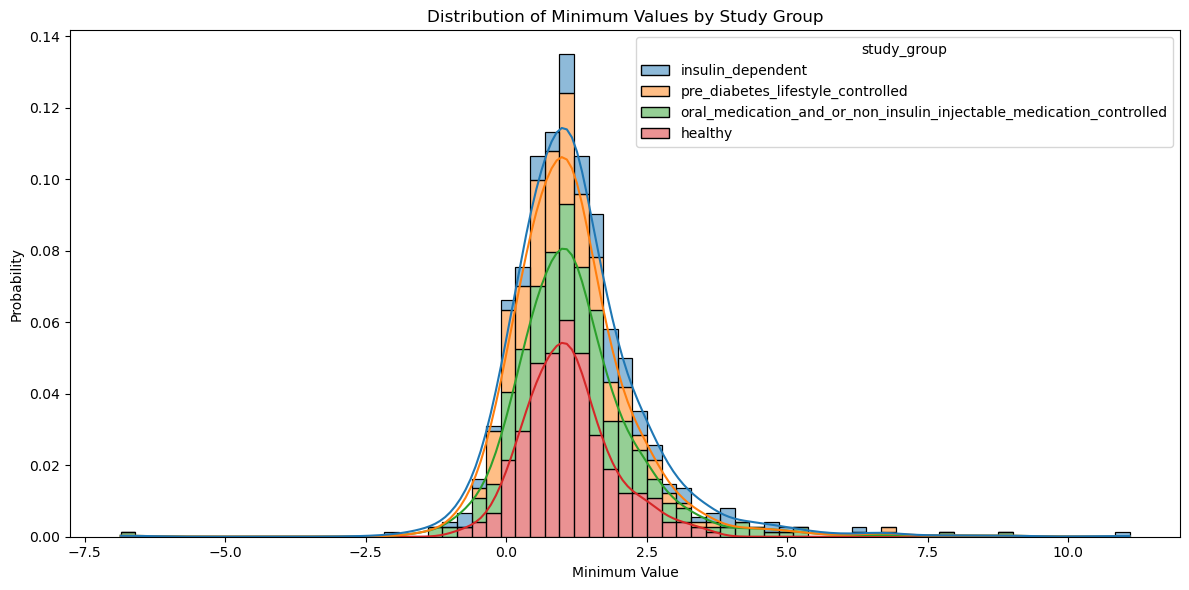

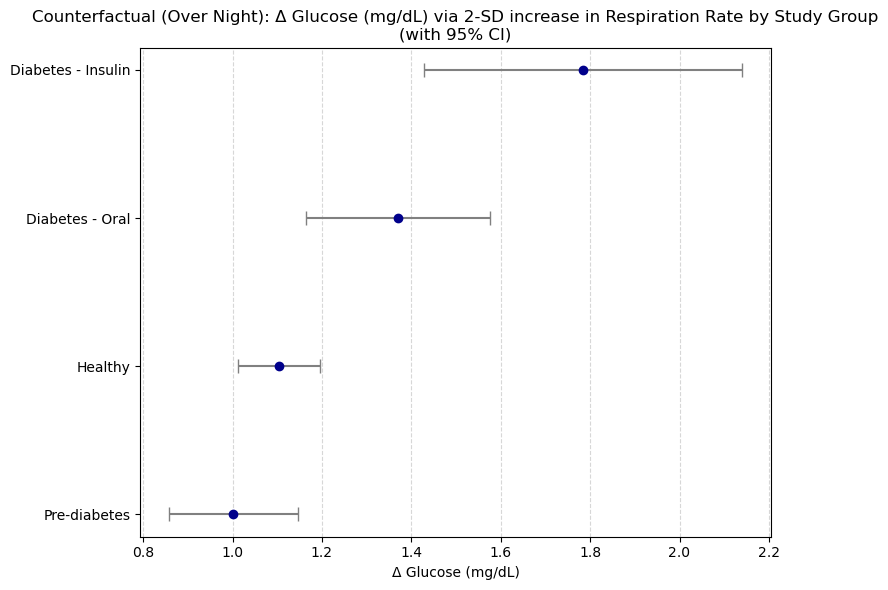

In [26]:
# Merge min_values with study group information
# df_min_values = pd.DataFrame(min_values, columns=['min_value'])
# df_min_values['participant_id'] = df_min_values.index
# df_min_values = df_min_values.merge(clinical_state, on='participant_id', how='left')
# df_min_values = df_min_values.set_index('participant_id')

df_min_values = pd.DataFrame(mean_values, columns=['min_value'])
df_min_values['participant_id'] = df_min_values.index
df_min_values = df_min_values.reset_index(drop=True)

# make sure participant_id is only a column, not an index
#clinical_state = clinical_state.reset_index()

df_min_values = df_min_values.merge(clinical_state, on='participant_id', how='left')
df_min_values = df_min_values.set_index('participant_id')

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(12, 6))
# sns.barplot(x=df_min_values.index, y='min_value', hue='study_group', data=df_min_values)
# plt.title('Minimum Values per Participant by Study Group')
# plt.xlabel('Participant ID')
# plt.ylabel('Minimum Value')
# plt.xticks(rotation=45)
# plt.legend(title='Study Group')
# plt.tight_layout()
# plt.show()

# Plot as distribution colored by study group - normalize the y axis
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df_min_values,
    x='min_value',
    hue='study_group',
    multiple='stack',
    kde=True,
    stat='probability'  # This makes the y-axis a probability distribution
)
plt.title('Distribution of Minimum Values by Study Group')
plt.xlabel('Minimum Value')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()


# Plot average effect and CI (or standard error) for each study group using df_min_values
# Order the study groups by their average minimum value
# Have it renamed (Healthy, Pre-diabetes, Diabetes - Oral, Diabetes - Insulin)
df_min_values['study_group'] = df_min_values['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})

# ['insulin_dependent' 'pre_diabetes_lifestyle_controlled'
#  'oral_medication_and_or_non_insulin_injectable_medication_controlled'
#  'healthy']

# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = df_min_values.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# Forest plot
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual (Over Night): Δ Glucose (mg/dL) via 2-SD increase in Respiration Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1) Tidy labels & order ---
df = df_min_values.copy()
df['study_group'] = df['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})
group_order = ['Healthy', 'Pre-diabetes', 'Diabetes - Oral', 'Diabetes - Insulin']
df['study_group'] = pd.Categorical(df['study_group'], categories=group_order, ordered=True)

# --- 2) Group stats (mean + 95% CI). Use t CI; switch to bootstrap if n is small/non-normal ---
# --- 2) Group stats (mean + 95% CI). Use t CI; switch to bootstrap if n is small/non-normal ---
def mean_ci(x):
    x = np.asarray(x.dropna())
    n = len(x)
    m = x.mean()
    se = x.std(ddof=1) / np.sqrt(n)
    tcrit = stats.t.ppf(0.975, df=n-1) if n > 1 else np.nan
    return pd.Series({
        'mean': m,
        'ci_lower': m - tcrit*se if n > 1 else np.nan,
        'ci_upper': m + tcrit*se if n > 1 else np.nan,
        'n': n
    })

gstats = (
    df.groupby('study_group')['min_value']
      .apply(mean_ci)         # produces a DataFrame
      .reset_index()          # reset the MultiIndex
)

# At this point gstats looks like:
#   study_group   level_1   0
# Rename properly:
gstats = gstats.pivot(index='study_group', columns='level_1', values=0).reset_index()

# --- 3) Unified plot ---
fig, ax = plt.subplots(figsize=(9, 6))

# horizontal violins per group
positions = np.arange(len(group_order))  # y positions
for i, grp in enumerate(group_order):
    vals = df.loc[df['study_group'] == grp, 'min_value'].dropna()
    if len(vals) == 0:
        continue
    parts = ax.violinplot(vals, positions=[i], vert=False, showextrema=False, widths=0.7)
    for pc in parts['bodies']:
        pc.set_alpha(0.25)

    # jittered individual dots
    y_jit = np.random.normal(loc=i, scale=0.06, size=len(vals))
    ax.plot(vals, y_jit, 'o', ms=4, alpha=0.65)

# overlay mean ± 95% CI as errorbars
for i, row in gstats.iterrows():
    y = positions[group_order.index(row['study_group'])]
    ax.errorbar(row['mean'], y,
                xerr=[[row['mean'] - row['ci_lower']], [row['ci_upper'] - row['mean']]],
                fmt='o', capsize=5, lw=1.5)

# cosmetics
ax.set_yticks(positions)
ax.set_yticklabels(group_order)
ax.set_xlabel('Counterfactual Δ Glucose (mg/dL) for 2-SD ↑ Respiration Rate (Overnight 9 PM–6 AM)')
ax.set_title('Individual Counterfactual Effects with Group Means and 95% CIs')
ax.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


/tmp/ipykernel_74218/1870019876.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('study_group')['min_value']


KeyError: 0